### load ECCO model output for SASSIE and make basic plots

k.drushka // feb 2022

data from: https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html

download data by mounting ECCO Drive locally (Linux) and then copying files (e.g., May 01-09, 2011): 
```
sudo mount.davfs https://ecco.jpl.nasa.gov/drive/files /mnt/ecco_drive/
cd /mnt/ecco_drive/ECCO2/SASSIE/2011_demo/
for d in * do
cp -u $d/*_2011-05-0*.nc /data1/sassie/model/2011_demo/$d/
done
```


some code to plot ECCO data from: https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html

In [1]:
## Imports 

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import time
import sys
import os
import glob as glob


import numpy as np
import pandas as pd
import xarray as xr

from xgcm import Grid
import xgcm.grid

# data visualizations
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.ticker as mticker


In [2]:
# directory where data are stored
basedir = '/data1/sassie/model/2011_demo/'

In [3]:
# load files with xarray:

# # all variables in a single xr dataset?
# dirs = glob.glob(basedir +'/*') 
# for d in dirs:
#     files = glob.glob(d + '/*nc') 
#     if not files==[]:
#         print(d, files)
        
        
# # all variables, each in its own xr dataset?
# dirs = glob.glob(basedir +'/*') 
# for d in dirs:
#     files = glob.glob(d + '/*nc') 
#     thisvar = d
#     if not files==[]:
#         print(d, files)        
        
        
# specify which var to open:
thisvar = 'SALT'
files = glob.glob(basedir + '/' + thisvar + '*_day_mean/*nc') 
print(files)        
        
          

['/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-08.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-05.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-09.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-03.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-04.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-02.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-07.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-01.nc', '/data1/sassie/model/2011_demo/SALT_day_mean/SALT_AVG_DAY_2011-05-06.nc']


In [4]:
# load files
# throws an error of decode_cf isn't specified 
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', decode_cf=False) 
# ds = xr.open_mfdataset(files, combine='nested', concat_dim='time') 
ds

<xarray.Dataset>
Dimensions:  (time: 9, j: 1080, i: 1440, k: 90)
Coordinates:
  * time     (time) int64 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: j, i, k
Data variables:
    XC       (time, j, i) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    YC       (time, j, i) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Z        (time, k) float32 dask.array<chunksize=(1, 90), meta=np.ndarray>
    Z_bot    (time, k) float32 dask.array<chunksize=(1, 90), meta=np.ndarray>
    Z_top    (time, k) float32 dask.array<chunksize=(1, 90), meta=np.ndarray>
    SALT     (time, k, j, i) float64 dask.array<chunksize=(1, 90, 1080, 1440), meta=np.ndarray>
Attributes:
    date_created:            2022-02-22T14:22:33
    date_modified:           2022-02-22T14:22:33
    date_metadata_modified:  2022-02-22T14:22:33
    date_issued:             2022-02-22T14:22:33

In [5]:
# load files
# throws an error of decode_cf isn't specified 
ds = xr.open_mfdataset(files,  decode_cf=False) 
ds

# # manually convert time - this is klugey but it seems to work.
# NO it doesn\'t work.

# ds = ds.swap_dims({'time':'time_temp'})
ds = ds.rename_dims({'time':'time_temp'})
# ds['time_temp'] = ds['time'].data
ds['time_temp'] 
# ds['time_temp'].attrs["units"] = ds['time'].attrs["units"]
# ds['time_temp'] = pd.date_range(
# ds['time_temp'].attrs["units"] = "days since 2011-01-01"
# ds = ds.swap_dims({'time':'time_temp'})
# ds['time'].attrs["units"] = "dum"
# ds['time'].attrs = []
# ds = ds.drop_dims('time')
# ds = ds.reset_coords('time')#.drop_vars('time')
# ds = xr.decode_cf(ds)
# ds = ds.swap_dims({'time_temp':'time'})
# ds = ds.rename_vars({'time_temp':'time'}).swap_dims({'time_temp':'time'})
ds

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [5]:
# XC, YC, Z are the same for each time, so redefine them
ds['XC'] = ds['XC'].isel(time=0)
ds['YC'] = ds['YC'].isel(time=0)
ds['Z'] = ds['Z'].isel(time=0)
ds['Z_bot'] = ds['Z_bot'].isel(time=0)
ds['Z_top'] = ds['Z_top'].isel(time=0)

In [7]:
# limit to the beaufort - this is crude and imprecise, but works
irange = slice(0, 500)
jrange = slice(0, 500)
ds = ds.sel(i=irange, j=jrange)
ds

<xarray.Dataset>
Dimensions:  (j: 500, i: 500, k: 90, time: 9)
Coordinates:
  * time     (time) int64 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: j, i, k
Data variables:
    XC       (j, i) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    Z_bot    (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    Z_top    (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    SALT     (time, k, j, i) float64 dask.array<chunksize=(1, 90, 500, 500), meta=np.ndarray>
Attributes:
    date_created:            2022-02-22T14:22:33
    date_modified:           2022-02-22T14:22:33
    date_metadata_modified:  2022-02-22T14:22:33
    date_issued:             2022-02-22T14:22:33

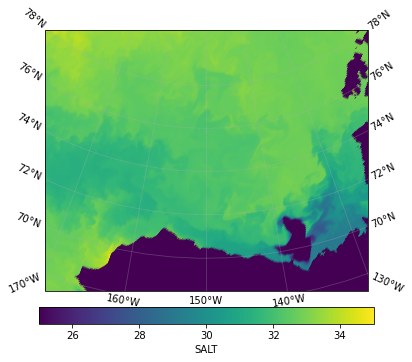

In [6]:
# plot using scatter

# index of time and depth to plot
ti = 0 
zi = 0

fig, ax1 = plt.subplots(1,1, 
        subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-150)}, 
        figsize=(6,6))

pc = ax1.scatter(ds.XC.data, 
                 ds.YC.data, 
                 c=ds[thisvar].isel(k=zi, time=ti).data,
                   transform=ccrs.PlateCarree(),
                   vmin = 25,
                   vmax = 35)

#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
# ax1.set_title()
plt.colorbar(pc, ax=ax1, orientation="horizontal", pad=0.05).set_label(thisvar)
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True

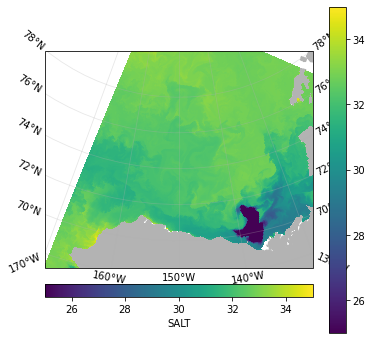

In [165]:
# or, plot with pcolor (much faster)
lons = ds.XC
lats = ds.YC
# index of time and depth to plot
ti = 0 
zi = 0
# mask zero data (assumed to be land) with nan
data_to_plot = ds[thisvar].isel(k=zi, time=ti).where(ds.SALT.isel(k=zi, time=ti) !=0,np.nan)

fig, ax1 = plt.subplots(1,1, 
        subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-150)}, 
        figsize=(6,6))

plt.pcolormesh(lons, lats, data_to_plot,
               transform=ccrs.PlateCarree(),
              vmin=25, vmax=35);
plt.colorbar()

#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
# ax1.set_title()
plt.colorbar(pc, ax=ax1, orientation="horizontal", pad=0.05).set_label(thisvar)
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True



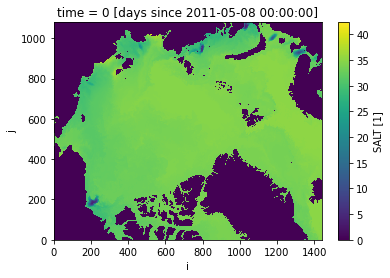

In [8]:
ds.SALT.isel(time=0, k=0).plot()

